In [1]:
import numpy
import math
from scipy.interpolate import UnivariateSpline
import scipy.optimize as opt
from scipy.optimize import fsolve
from scipy import signal
from scipy import ndimage
import pandas
import posixpath as pp
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Landsat

In [2]:
# ls8oli = pandas.read_excel('Ball_BA_RSR.xlsx', sheetname=None)
# ls8tirs = pandas.read_excel('TIRS_Relative_Spectral_ResponsesBA.xlsx', sheetname=['TIRS BA RSR'])
# ls5tm = pandas.read_excel('L5_TM_RSR.xlsx', sheetname=None)
# ls7etm = pandas.read_excel('L7_RSR.xlsx', sheetname=['Blue-L7','Green-L7','Red-L7','NIR-L7',
#                                                      'SWIR(5)-L7','SWIR(7)-L7','Pan-L7'])

### MODIS

In [3]:
sname = 'modis_fm1_rsp_mid_chnl_sum'
modis_df = pandas.read_excel('MODIS_FM1_IB_OOB_RSR_merged.xls', sheetname=[sname])[sname]

In [4]:
modis_df.head()

,Band 1,Band 1RSR,Band 2,Band 2RSR,Band 3,Band 3RSR,Band 4,Band 4RSR,Band 5,Band 5RSR,...,Band 32,Band 32RSR,Band 33,Band 33RSR,Band 34,Band 34RSR,Band 35,Band 35RSR,Band 36,Band 36RSR
0,0.35,5.270000e-04,0.35,0.000614,0.35,0.000632,0.35,0.000626,1.196514,0.00004,...,1.10,0.000035,1.10,0.000063,1.10,0.000024,1.10,0.000012,1.10,0.000086
1,0.36,1.000000e-08,0.36,0.000153,0.36,0.000158,0.36,0.000644,1.197975,0.00012,...,1.12,0.000025,1.12,0.000032,1.12,0.000074,1.12,0.000046,1.12,0.000082
2,0.37,8.130000e-04,0.37,0.000276,0.37,0.000569,0.37,0.000091,1.199481,0.00016,...,1.14,0.000031,1.14,0.000003,1.14,0.000065,1.14,0.000121,1.14,0.000043
3,0.38,7.350000e-05,0.38,0.000200,0.38,0.000382,0.38,0.000033,1.200981,0.00019,...,1.16,0.000067,1.16,0.000025,1.16,0.000036,1.16,0.000031,1.16,0.000011
4,0.39,4.630000e-04,0.39,0.000220,0.39,0.000268,0.39,0.000206,1.202475,0.00043,...,1.18,0.000002,1.18,0.000012,1.18,0.000048,1.18,0.000008,1.18,0.000015


In [5]:
# 'Wavelength1', 'Band1RSR', 'Wavelength2', 'Band2RSR'
cols = {}
for i in range(1, 37):
    key1 = 'Band {}'.format(i)
    key2 = 'Band {}RSR'.format(i)
    value1 = 'Wavelength{}'.format(i)
    value2 = 'Band{}'.format(i)
    cols[key1] = value1
    cols[key2] = value2
modis_df.rename(columns=cols, inplace=True)

In [6]:
modis_df.head()

,Wavelength1,Band1,Wavelength2,Band2,Wavelength3,Band3,Wavelength4,Band4,Wavelength5,Band5,...,Wavelength32,Band32,Wavelength33,Band33,Wavelength34,Band34,Wavelength35,Band35,Wavelength36,Band36
0,0.35,5.270000e-04,0.35,0.000614,0.35,0.000632,0.35,0.000626,1.196514,0.00004,...,1.10,0.000035,1.10,0.000063,1.10,0.000024,1.10,0.000012,1.10,0.000086
1,0.36,1.000000e-08,0.36,0.000153,0.36,0.000158,0.36,0.000644,1.197975,0.00012,...,1.12,0.000025,1.12,0.000032,1.12,0.000074,1.12,0.000046,1.12,0.000082
2,0.37,8.130000e-04,0.37,0.000276,0.37,0.000569,0.37,0.000091,1.199481,0.00016,...,1.14,0.000031,1.14,0.000003,1.14,0.000065,1.14,0.000121,1.14,0.000043
3,0.38,7.350000e-05,0.38,0.000200,0.38,0.000382,0.38,0.000033,1.200981,0.00019,...,1.16,0.000067,1.16,0.000025,1.16,0.000036,1.16,0.000031,1.16,0.000011
4,0.39,4.630000e-04,0.39,0.000220,0.39,0.000268,0.39,0.000206,1.202475,0.00043,...,1.18,0.000002,1.18,0.000012,1.18,0.000048,1.18,0.000008,1.18,0.000015


### Sentinel 2A

In [7]:
sname = 'Spectral Responses'
s2amsi_df = pandas.read_excel('Sentinel-2A MSI Spectral Responses.xlsx', sheetname=[sname])[sname]

In [8]:
s2amsi_df.head()

,SR_WL,Band 1,Band 2,Band 3,Band 4,Band 5,Band 6,Band 7,Band 8,Band 8A,Band 9,Band 10,Band 11,Band 12
0,300,0,0,0,0,0,0,0,0,0,0,0,0,0
1,301,0,0,0,0,0,0,0,0,0,0,0,0,0
2,302,0,0,0,0,0,0,0,0,0,0,0,0,0
3,303,0,0,0,0,0,0,0,0,0,0,0,0,0
4,304,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
cols = {'SR_WL': 'Wavelength1',
        'Band 8A': 'Band8A'}
for i in range(1, 13):
    key = 'Band {}'.format(i)
    value = 'Band{}'.format(i)
    cols[key] = value
s2amsi_df.rename(columns=cols, inplace=True)

Create wavelength columns for each band

In [10]:
for i in range(2, 13):
    col = 'Wavelength{}'.format(i)
    s2amsi_df[col] = s2amsi_df['Wavelength1']
s2amsi_df['Wavelength8A'] = s2amsi_df['Wavelength1']

Reorder the columns to keep the same format as other dataframes eg ['Wavelength1', 'Band1']

In [11]:
tmp = [(['Wavelength{}'.format(i), 'Band{}'.format(i)]) for i in range(1, 13)]
cols = []
for i in tmp:
    cols.extend(i)
cols.insert(16, 'Wavelength8A')
cols.insert(17, 'Band8A')
s2amsi_df = s2amsi_df[cols]

In [12]:
s2amsi_df.head()

,Wavelength1,Band1,Wavelength2,Band2,Wavelength3,Band3,Wavelength4,Band4,Wavelength5,Band5,...,Wavelength8A,Band8A,Wavelength9,Band9,Wavelength10,Band10,Wavelength11,Band11,Wavelength12,Band12
0,300,0,300,0,300,0,300,0,300,0,...,300,0,300,0,300,0,300,0,300,0
1,301,0,301,0,301,0,301,0,301,0,...,301,0,301,0,301,0,301,0,301,0
2,302,0,302,0,302,0,302,0,302,0,...,302,0,302,0,302,0,302,0,302,0
3,303,0,303,0,303,0,303,0,303,0,...,303,0,303,0,303,0,303,0,303,0
4,304,0,304,0,304,0,304,0,304,0,...,304,0,304,0,304,0,304,0,304,0


### ASTER
* http://asterweb.jpl.nasa.gov/content/01_mission/03_instrument/archive/swir.txt
* http://asterweb.jpl.nasa.gov/content/01_mission/03_instrument/archive/vnir.txt
* http://asterweb.jpl.nasa.gov/content/01_mission/03_instrument/archive/tir.txt

#### ASTER VNIR

In [13]:
astervnir = pandas.read_csv('aster/vnir.txt', delim_whitespace=True, header=3)

In [14]:
astervnir.head()

,[um],Response,[um].1,Response.1,[um].2,Response.2,[um].3,Response.3
0,0.480,0.0000,0.590,0.0038,0.720,0.0022,0.720,0.0099
1,0.484,0.0069,0.593,0.0032,0.724,0.0000,0.724,0.0088
2,0.488,0.0078,0.596,0.0000,0.728,0.0093,0.728,0.0206
3,0.492,0.0073,0.599,0.0019,0.732,0.0258,0.732,0.0384
4,0.496,0.0107,0.602,0.0031,0.736,0.0480,0.736,0.0657


In [15]:
cols = {'[um]': 'Wavelength1',
        'Response': 'Band1',
        '[um].3': 'Wavelength3B',
        'Response.3': 'Band3B'}
for i in range(1, 3):
    key1 = '[um].{}'.format(i)
    key2 = 'Response.{}'.format(i)
    value1 = 'Wavelength{}'.format(i + 1)
    value2 = 'Band{}'.format(i + 1)
    cols[key1] = value1
    cols[key2] = value2
astervnir.rename(columns=cols, inplace=True)

In [16]:
astervnir.head()

,Wavelength1,Band1,Wavelength2,Band2,Wavelength3,Band3,Wavelength3B,Band3B
0,0.480,0.0000,0.590,0.0038,0.720,0.0022,0.720,0.0099
1,0.484,0.0069,0.593,0.0032,0.724,0.0000,0.724,0.0088
2,0.488,0.0078,0.596,0.0000,0.728,0.0093,0.728,0.0206
3,0.492,0.0073,0.599,0.0019,0.732,0.0258,0.732,0.0384
4,0.496,0.0107,0.602,0.0031,0.736,0.0480,0.736,0.0657


#### ASTER SWIR

In [17]:
asterswir = pandas.read_csv('aster/swir.txt', delim_whitespace=True, header=3)

In [18]:
cols = {'(um)': 'Wavelength4',
        'Resp': 'Band4'}
for i in range(1, 6):
    key1 = '(um).{}'.format(i)
    key2 = 'Resp.{}'.format(i)
    value1 = 'Wavelength{}'.format(i + 4)
    value2 = 'Band{}'.format(i + 4)
    cols[key1] = value1
    cols[key2] = value2
asterswir.rename(columns=cols, inplace=True)

In [19]:
asterswir.head()

,Wavelength4,Band4,Wavelength5,Band5,Wavelength6,Band6,Wavelength7,Band7,Wavelength8,Band8,Wavelength9,Band9
0,1.000,0,1.000,0,1.000,0,1.000,0,1.000,0,1.000,0
1,1.048,0,1.048,0,1.048,0,1.048,0,1.048,0,1.048,0
2,1.096,0,1.096,0,1.096,0,1.096,0,1.096,0,1.096,0
3,1.144,0,1.144,0,1.144,0,1.144,0,1.144,0,1.144,0
4,1.192,0,1.192,0,1.192,0,1.192,0,1.192,0,1.192,0


#### ASTER TIR

In [20]:
astertir = pandas.read_csv('aster/tir.txt', delim_whitespace=True, header=3)

In [21]:
cols = {'(um)': 'Wavelength10',
        'Resp': 'Band10'}
for i in range(1, 5):
    key1 = '(um).{}'.format(i)
    key2 = 'Resp.{}'.format(i)
    value1 = 'Wavelength{}'.format(i + 10)
    value2 = 'Band{}'.format(i + 10)
    cols[key1] = value1
    cols[key2] = value2
astertir.rename(columns=cols, inplace=True)

In [22]:
astertir.head()

,Wavelength10,Band10,Wavelength11,Band11,Wavelength12,Band12,Wavelength13,Band13,Wavelength14,Band14
0,8.00,0.0000,8.00,0.0000,8.00,0.0000,8.00,0.0000,8.00,0.0000
1,8.01,0.0000,8.01,0.0003,8.01,0.0014,8.01,0.0003,8.01,0.0000
2,8.02,0.0000,8.02,0.0001,8.02,0.0009,8.02,0.0002,8.02,0.0001
3,8.03,0.0022,8.03,0.0000,8.03,0.0009,8.03,0.0000,8.03,0.0000
4,8.04,0.0123,8.04,0.0000,8.04,0.0008,8.04,0.0002,8.04,0.0000


### Himawari 8 
* http://www.data.jma.go.jp/mscweb/en/himawari89/space_segment/spsg_ahi.html

In [23]:
h8ahi = pandas.read_excel('h8/AHI-8_SpectralResponsivity_Data.xlsx', sheetname=['Band 1','Band 2','Band 3',
                                                                                'Band 4','Band 5','Band 6',
                                                                                'Band 7','Band 8','Band 9',
                                                                                'Band 10','Band 11','Band 12',
                                                                                'Band 13','Band 14','Band 15',
                                                                                'Band 16'], header=2)
for key in h8ahi:
    h8ahi[key].drop(0, inplace=True)
    h8ahi[key].drop('Wavenumber', axis=1, inplace=True)
    h8ahi[key] = h8ahi[key].convert_objects(convert_numeric=True)

In [24]:
h8ahi['Band 6'].head(3)

,Wavelength,Relative Responsivity
1,2.187705,0.000617
2,2.188184,0.000617
3,2.188663,0.000535


In [25]:
for key in h8ahi:
    b, n = key.split(' ')
    cols = {'Wavelength': 'Wavelength{}'.format(n),
            'Relative Responsivity': 'Band{}'.format(n)}
    h8ahi[key].rename(columns=cols, inplace=True)

In [26]:
h8ahi['Band 6'].head(3)

,Wavelength6,Band6
1,2.187705,0.000617
2,2.188184,0.000617
3,2.188663,0.000535


### Writing pandas dataframes to disk

In [27]:
store = pandas.HDFStore('spectral-responses.h5', 'w', complevel=4, complib='blosc')

In [28]:
# store['landsat5/tm']
store['terra/modis'] = modis_df
store['sentinel_2a/msi'] = s2amsi_df
store['terra/astervnir'] = astervnir
store['terra/asterswir'] = asterswir
store['terra/astertir'] = astertir
for key in h8ahi:
    bname = key.replace(' ', '')
    pth_name = 'himawari8/{}'.format(bname)
    store[pth_name] = h8ahi[key]

In [29]:
node = store.get_storer('terra/modis')
node.attrs.units = u"\u03BCm"
node.attrs.scale_factor = 1000

In [30]:
node = store.get_storer('sentinel_2a/msi')
node.attrs.units = 'nm'
node.attrs.scale_factor = 1

In [31]:
node = store.get_storer('terra/astervnir')
node.attrs.units = u"\u03BCm"
node.attrs.scale_factor = 1000

In [32]:
node = store.get_storer('terra/asterswir')
node.attrs.units = u"\u03BCm"
node.attrs.scale_factor = 1000

In [33]:
node = store.get_storer('terra/astertir')
node.attrs.units = u"\u03BCm"
node.attrs.scale_factor = 1000

In [34]:
for i in range(1, 17):
    pth = 'himawari8/Band{}'.format(i)
    node = store.get_storer(pth)
    node.attrs.units = u"\u03BCm"
    node.attrs.scale_factor = 1000

In [35]:
store.close()

### Reading

In [36]:
store = pandas.HDFStore('spectral-responses.h5', 'r')
store

<class 'pandas.io.pytables.HDFStore'>
File path: spectral-responses.h5
/himawari8/Band1             frame        (shape->[5449,2]) 
/himawari8/Band10            frame        (shape->[1332,2]) 
/himawari8/Band11            frame        (shape->[1291,2]) 
/himawari8/Band12            frame        (shape->[991,2])  
/himawari8/Band13            frame        (shape->[981,2])  
/himawari8/Band14            frame        (shape->[1491,2]) 
/himawari8/Band15            frame        (shape->[1631,2]) 
/himawari8/Band16            frame        (shape->[771,2])  
/himawari8/Band2             frame        (shape->[3279,2]) 
/himawari8/Band3             frame        (shape->[4143,2]) 
/himawari8/Band4             frame        (shape->[1489,2]) 
/himawari8/Band5             frame        (shape->[507,2])  
/himawari8/Band6             frame        (shape->[276,2])  
/himawari8/Band7             frame        (shape->[3557,2]) 
/himawari8/Band8             frame        (shape->[4201,2]) 
/himawari8/Ban

In [37]:
node = store.get_storer('terra/astertir')
print u"Wavelength Units: {}".format(node.attrs.units)
print "Scale factor: {}".format(node.attrs.scale_factor)

Wavelength Units: μm
Scale factor: 1000


We could also define some reader that will apply scale factors to the wavelengths on the fly

In [38]:
def read_specral_resonse(store, pth):
    df = store[pth]
    sf = store.get_storer(pth).attrs.scale_factor
    res = df.filter(regex='Wavelength*') * sf
    for col in res.columns:
        df[col] = res[col]
    return df

In [39]:
store['terra/astervnir'].head(5)

,Wavelength1,Band1,Wavelength2,Band2,Wavelength3,Band3,Wavelength3B,Band3B
0,0.480,0.0000,0.590,0.0038,0.720,0.0022,0.720,0.0099
1,0.484,0.0069,0.593,0.0032,0.724,0.0000,0.724,0.0088
2,0.488,0.0078,0.596,0.0000,0.728,0.0093,0.728,0.0206
3,0.492,0.0073,0.599,0.0019,0.732,0.0258,0.732,0.0384
4,0.496,0.0107,0.602,0.0031,0.736,0.0480,0.736,0.0657


In [40]:
read_specral_resonse(store, 'terra/astervnir').head(5)

,Wavelength1,Band1,Wavelength2,Band2,Wavelength3,Band3,Wavelength3B,Band3B
0,480,0.0000,590,0.0038,720,0.0022,720,0.0099
1,484,0.0069,593,0.0032,724,0.0000,724,0.0088
2,488,0.0078,596,0.0000,728,0.0093,728,0.0206
3,492,0.0073,599,0.0019,732,0.0258,732,0.0384
4,496,0.0107,602,0.0031,736,0.0480,736,0.0657


In [41]:
df = read_specral_resonse(store, 'terra/astervnir')
df2 = read_specral_resonse(store, 'sentinel_2a/msi')

[300, 1100, 0, 1]

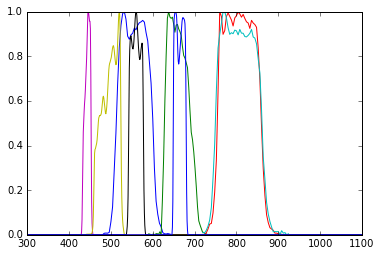

In [42]:
fig, axes = subplots(nrows=1)
plot(df['Wavelength1'].values, df['Band1'].values)
plot(df['Wavelength2'].values, df['Band2'].values)
plot(df['Wavelength3'].values, df['Band3'].values)
plot(df['Wavelength3B'].values, df['Band3B'].values)
plot(df2['Wavelength1'].values, df2['Band1'].values)
plot(df2['Wavelength2'].values, df2['Band2'].values)
plot(df2['Wavelength3'].values, df2['Band3'].values)
plot(df2['Wavelength4'].values, df2['Band4'].values)
axes.axis([300, 1100, 0, 1])

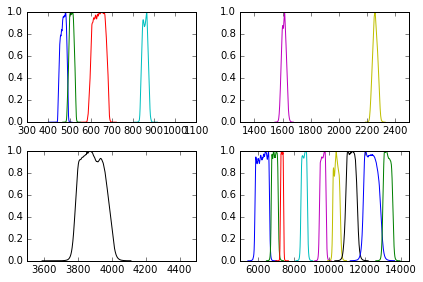

In [43]:
fig, axes = subplots(nrows=2, ncols=2)
for i in range(1, 17):
    bname = 'Band{}'.format(i)
    pth_name = pp.join('himawari8', bname)
    df = read_specral_resonse(store, pth_name)
    wname = 'Wavelength{}'.format(i)
    axes[0, 0].plot(df[wname].values, df[bname].values)
    axes[0, 0].axis([300, 1100, 0, 1])
    axes[0, 1].plot(df[wname].values, df[bname].values)
    axes[0, 1].axis([1300, 2500, 0, 1])
    axes[1, 0].plot(df[wname].values, df[bname].values)
    axes[1, 0].axis([3500, 4500, 0, 1])
    axes[1, 1].plot(df[wname].values, df[bname].values)
    axes[1, 1].axis([5000, 14500, 0, 1])
tight_layout()

In [44]:
store.close()